# TP1 - Neural Networks from scratch

The architecture of this code is freely inspired from the torch and pytorch architectures, and some sample of code are re-used. It is however designed to be as concise as possible, not in any case for efficiency or flexibility (i.e. if you ever want to do Deep Learning out of this class, don't try to adapt this code, use an existing framework).

Following code allows you to mount your drive in the Colab Virtual Machine in order to get access to the data (skipped if run locally)

In [ ]:
try:
  from google.colab import drive
  drive.mount('/content/gdrive', force_remount=True)

  FOLDERNAME = 'DEEPL_TP_1'
  %cd /content/gdrive/My\ Drive/DEEPL/$FOLDERNAME
except ImportError:
  pass

Mounted at /content/gdrive
/content/gdrive/My Drive/DEEPL/DEEPL_TP_1


## Part 0. A simple Multi-Layer Perceptron (MLP) implementation

As always some useful imports:

In [ ]:
import math
import random
import numpy as np
import matplotlib.pyplot as plt 
plt.rcParams['image.cmap'] = 'gray' 
import scipy.ndimage as ndimage
import scipy.optimize as optimize

import os

try:
    # tqdm is a very useful library to monitor the progression of your loops
    # (not necessary but handy)
    from tqdm.notebook import tqdm
except ImportError:
    pass

We will consider a Neural Network as a modular architecture, all layer and loss being a `Module`. We define the `Linear`, `ReLU` layers, necessary to implement a MLP, as well as a simple 2-layer MLP and the least square loss function, `LeastSquareCriterion`.

In [ ]:
class Module(object):
    def __init__(self):
        self.gradInput = None 
        self.output = None
        
    def forward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError
        
    def backward(self, *input):
        """
        Defines the computation performed at every call.
        Should be overriden by all subclasses.
        """
        raise NotImplementedError


class LeastSquareCriterion(Module):
    """
    This implementation of the least square loss assumes that the data comes as a 2-dimensional array
    of size (batch_size, num_classes) and the labels as a vector of size (num_classes) 
    """
    def __init__(self, num_classes=10):
        super(LeastSquareCriterion, self).__init__()
        self.num_classes = num_classes
    
    def forward(self, x, labels):
        target = np.zeros([x.shape[0], self.num_classes])
        for i in range(x.shape[0]):
            target[i, labels[i]] = 1
        self.output = np.sum((target-x)**2, axis=1)
        return np.mean(self.output)
    
    def backward(self, x, labels):
        self.gradInput = x
        for i in range(x.shape[0]):
            self.gradInput[i, labels[i]] = x[i, labels[i]]-1
        return self.gradInput
    

class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = (
            math.sqrt(1. / (out_features*in_features)) * 
            np.random.randn(out_features, in_features)
        )
        self.bias = np.zeros(out_features)
        
        self.gradWeight = None
        self.gradBias = None

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr):
        self.weight = self.weight - lr*self.gradWeight
        self.bias = self.bias - lr*self.gradBias
        

class ReLU(Module):
    def __init__(self, bias=True):
        super(ReLU, self).__init__()
        
    def forward(self, x):
        self.output = x.clip(0)
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = (x>0) * gradOutput
        return self.gradInput


class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self, in_dimension=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, 64)
        self.relu1 = ReLU()
        self.fc2 = Linear(64, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

## Part I. Training a neural network

To train a network, we will need data. Download the Mini-MNIST data (~4Mo). It consists of 28×28 images (loaded as vectors of size 784) and the associated label for training and test sets.

5


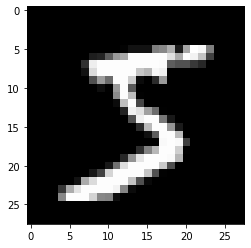

In [ ]:
data = np.load("mini_mnist.npz")

train_data = data["train_data"]
train_labels = data["train_labels"]
test_data = data["test_data"]
test_labels = data["test_labels"]

N_train = train_data.shape[0]
N_test = test_data.shape[0]

# Check that data makes sense
plt.figure()
plt.imshow(train_data[0, :].reshape(28,28))
print(train_labels[0])
plt.show()

Read and understand the code provided above

**Q1.a.** Write a function `train_iter(model, loss, batch_data, batch_labels, lr)` that trains one iteration of a given `model` and `loss` (subclasses of `Module`) on a batch `(batch_data, batch_labels)` with a learning rate `lr`, and returns the training loss value. <br/>
**Q1.b.** Test your function: write a simple loop that trains for 50 iterations a `SimpleMLP` on `train_data` with a learning rate `1e-3` and batches of size `16`.

*Note: An **iteration** consists in running one batch through the model; an **epoch** consists in running multiple iterations so as to process each example of the training set once.*

In [ ]:
#1a
def train_iter(model, loss, batch_data, batch_labels, lr):
  output = model.forward(batch_data)
  loss_value = loss.forward(output,batch_labels)
  gradient = loss.backward(output,batch_labels)
  model.backward(batch_data, gradient)
  model.gradientStep(lr)

  return loss_value


#1b
model = SimpleMLP()
loss = LeastSquareCriterion()
for i in range(50):
  random_index = random.randint(0,N_train-17)
  batch_data = train_data[random_index:random_index+16]
  batch_labels = train_labels[random_index:random_index+16]

  loss_value = train_iter(model,loss, batch_data, batch_labels, 1e-3)

  print(loss_value)

0.9993857715424449
0.9911750427097613
0.976873898365131
0.9794993194129671
0.9793473465219331
0.9548477792592588
0.9645177708393466
0.9459851419529226
0.9495682741911589
0.9418324084527583
0.9434241767527716
0.9348110716789662
0.930374905598757
0.9093993359099845
0.902563346818045
0.8978875786015532
0.8879790756441579
0.8844388710445152
0.89403739460211
0.8935154029954664
0.8671886236783938
0.8921416870878021
0.8787967371651874
0.8783768510162242
0.8844492254225227
0.8915648340382153
0.8530937058916139
0.8719997612882979
0.8818169932791732
0.8492481262698472
0.8396572068681596
0.8236192597710837
0.8535639166625002
0.8494386770070324
0.8547032799942769
0.8544150896504679
0.8739994408611538
0.8509358192604148
0.8567660080531272
0.8253320962320936
0.8460239796184503
0.8546932148670914
0.8284025044276948
0.8438127016569062
0.8235721951743147
0.7996777323266131
0.8249150200913156
0.8257048359910586
0.827435949630033
0.8233951280082037


**Q2.a.** Write a function `evaluate(model, loss, data, labels)` that returns a couple `(loss, accuracy)` corresponding to the loss and accuracy computed on the whole `data`. <br/>
**Q2.b.** Use your function to evaluate the model trained in question **1.b.** on the training and testing data. <br/> 
**Q2.c.** Check visually the quality of the results by plotting a few examples and their predictions.

In [ ]:
#2a
def evaluate(model, loss, data, labels):
  output = model.forward(data)
  loss_value = loss.forward(output,labels)

  accuracy = 0
  for i in range(output.shape[0]):
    predicted_label = np.argmax(output[i])
    if predicted_label == labels[i]:
      accuracy += 1
  accuracy /= output.shape[0]
    

  return (loss_value,accuracy)

#2b
print(evaluate(model,loss,train_data,train_labels))
print(evaluate(model,loss,test_data,test_labels))

(0.8154026677166557, 0.6322)
(0.8282297546150758, 0.5885)


predicted label :  9
true label :  4


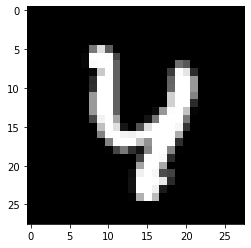

predicted label :  2
true label :  8


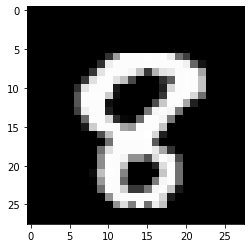

predicted label :  2
true label :  2


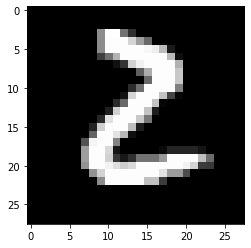

predicted label :  9
true label :  4


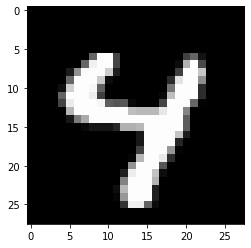

predicted label :  2
true label :  8


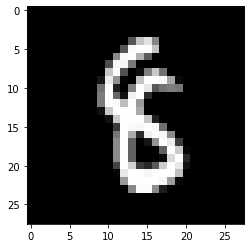

In [ ]:
#2c
output = model.forward(test_data)
for _ in range(5):
  i = random.randint(0,N_test-1)
  plt.figure()
  plt.imshow(test_data[i, :].reshape(28,28))
  print("predicted label : ", np.argmax(output[i]))
  print("true label : ", test_labels[i])
  plt.show()


**Q3.** Write a loop that trains a `SimpleMLP` for a whole epoch with the same parameters as in question **1.a.**. Plot the training and testing losses and accuracies during this training. 

*Note: you don't have to evaluate your network at every iteration, you can for example do it every 10 iterations*

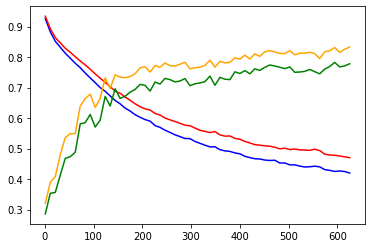

In [ ]:
#3
model = SimpleMLP()
loss = LeastSquareCriterion()
training_loss = []
testing_loss = []
training_accuracy = []
testing_accuracy = []
iterations = 0
for i in range(int(N_train/16)):                    #I checked that this is an integer (before conversion) so as to ensure that we use every picture
  iterations += 1
  batch_data = train_data[i*16:(i+1)*16]
  batch_labels = train_labels[i*16:(i+1)*16]
  train_iter(model,loss, batch_data, batch_labels, 1e-3)

  if iterations == 10:
    training_loss.append(evaluate(model,loss,train_data,train_labels)[0])
    training_accuracy.append(evaluate(model,loss,train_data,train_labels)[1])
    testing_loss.append(evaluate(model,loss,test_data,test_labels)[0])
    testing_accuracy.append(evaluate(model,loss,test_data,test_labels)[1])
    iterations = 0



X = np.linspace(1,int(N_train/16),int(N_train/16/10))
plt.plot(X,training_loss, 'blue')
plt.plot(X,testing_loss, 'red')
plt.plot(X,training_accuracy, 'orange')
plt.plot(X,testing_accuracy, 'green')

**Q4.a.** Based on the previous questions, design a function 

<center><pre>train(model, loss, train_data, train_labels, test_data, test_labels, ...)</pre></center>

that performs a full training of the input `model` on the training data. Choose the arguments of your function (for instance, `batch_size`, `lr`, `epochs`, etc) according to what seems relevant to you. This function should plot the training and validation losses and accuracies during training. <br/>
**Q4.b.** Use your function to train a model with a good accuracy (decide for a learning rate, batch size...)

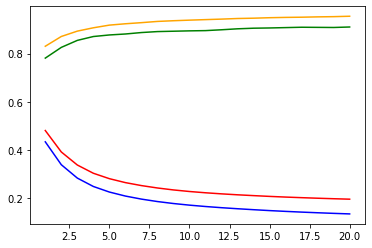

In [ ]:
#4a
def train(model, loss, train_data, train_labels, test_data, test_labels, batch_size, lr, epoch):
  training_loss = []
  testing_loss = []
  training_accuracy = []
  testing_accuracy = []
  for _ in range(epoch):
    for i in range(int(N_train/batch_size)): 
      batch_data = train_data[i*batch_size:(i+1)*batch_size]
      batch_labels = train_labels[i*batch_size:(i+1)*batch_size]

      train_iter(model,loss, batch_data, batch_labels, lr)
    
    training_loss.append(evaluate(model,loss,train_data,train_labels)[0])
    training_accuracy.append(evaluate(model,loss,train_data,train_labels)[1])
    testing_loss.append(evaluate(model,loss,test_data,test_labels)[0])
    testing_accuracy.append(evaluate(model,loss,test_data,test_labels)[1])

  X = np.linspace(1,epoch,epoch)
  plt.plot(X,training_loss, 'blue')
  plt.plot(X,testing_loss, 'red')
  plt.plot(X,training_accuracy, 'orange')
  plt.plot(X,testing_accuracy, 'green')


#4b
model = SimpleMLP()
loss = LeastSquareCriterion()

train(model, loss, train_data, train_labels, test_data, test_labels, 32, 1e-3, 20)

## Part II. Overfitting

**Q5.** What's the number of parameters in the network `SimpleMLP` used in the first section?

5. In our MLP there are 3 hidden layers. The entry has 784 parameters (pixels), the first layer (linear) 64, the second layer (relu) has no parameter, the third (linear) has 64, the output has 10 parameters (classes). Thus there are $784\times 64 + 64\times0 + 0\times64 + 64\times10 = 50816$ parameters in total.

**Q6.a.** Modify the definition of `SimpleMLP` to allow changing the dimension of the hidden layer. <br/>
**Q6.b.** Define a class `DoubleMLP` with three `Linear` layers, and parameters to change their dimensions. <br/>
**Q6.c.** Define a class `DeepMLP` with a **list** parameter `hidden_features` that allows to vary the number of intermediate linear layers, and their dimensions:

- `DeepMLP([64])` should be equivalent to `SimpleMLP()`;
- `DeepMLP([64, 64, 64])` should be a MLP with four linear layers...

**Q6.d.** Test your new classes: train a `DoubleMLP(64, 32)` and plot its performance

In [ ]:
#6a
class SimpleMLP(Module):
    """
    This class is a simple example of a neural network, composed of two
    linear layers, with a ReLU non-linearity in the middle
    """
    def __init__(self,hidden_layer_dimension, in_dimension=784, num_classes=10):
        super(SimpleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_layer_dimension)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_layer_dimension, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

#6b
class DoubleMLP(Module):
    def __init__(self,hidden_layer_dimension_1, hidden_layer_dimension_2, in_dimension=784, num_classes=10):
        super(DoubleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_layer_dimension_1)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_layer_dimension_1, hidden_layer_dimension_2)
        self.relu2 = ReLU()
        self.fc3 = Linear(hidden_layer_dimension_2, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output, gradient)
        gradient = self.relu2.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fc3.gradientStep(lr)
        self.fc2.gradientStep(lr)
        self.fc1.gradientStep(lr)
        return True

#6c
class DeepMLP(Module):
    def __init__(self, hidden_layers, in_dimension=784, num_classes=10):
        super(DeepMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_layers[0])
        self.fcs = [Linear(hidden_layers[i],hidden_layers[i+1]) for i in range(len(hidden_layers)-1)]
        self.fcl = Linear(hidden_layers[-1],num_classes)
        
        self.relu = ReLU()
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu.forward(x)
        for i in range(len(self.fcs)):
          x = self.fcs[i].forward(x)
          x = self.relu.forward(x)
        x = self.fcl.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fcl.backward(self.relu.output, gradient)
        for i in range(len(self.fcs)-1,0,-1):
          gradient = self.relu.backward(self.fcs[i].output, gradient)
          gradient = self.fcs[i].backward(self.fcs[i-1].output, gradient)
        gradient = self.relu.backward(self.fcs[0].output, gradient)
        gradient = self.fcs[0].backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr):
        self.fcl.gradientStep(lr)
        for i in range(len(self.fcs)-1,-1,-1):
          self.fcs[i].gradientStep(lr)
        return True

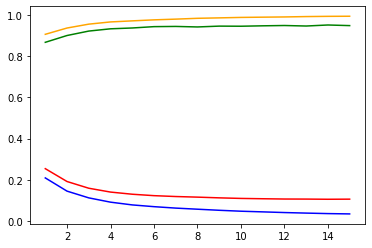

In [ ]:
#6d
model = DoubleMLP(64, 32)
train(model, loss,train_data, train_labels, test_data, test_labels, 32, 1e-2, 15)

**Q7.** Add to `Linear` and one of your MLP classes an optional parameter for (L2) weight decay (in the `gradientStep` functions) and show that it can reduce overfitting in some cases.

*(Note: improving the validation performance may be hard; you can look at a setting with only very little training data to see, and focus on showing that the gap between training and validation performance decreases)*

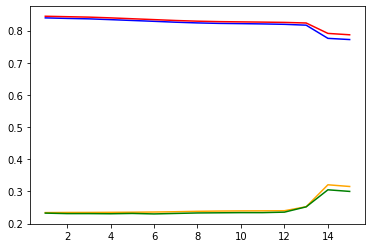

In [ ]:
#7
class Linear(Module):
    """
    The input is supposed to have two dimensions (batch_size, in_features)
    """
    def __init__(self, in_features, out_features, bias=True):
        super(Linear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        
        self.weight = (
            math.sqrt(1. / (out_features*in_features)) * 
            np.random.randn(out_features, in_features)
        )
        self.bias = np.zeros(out_features)
        
        self.gradWeight = None
        self.gradBias = None

    def forward(self, x):
        self.output = np.dot(x, self.weight.transpose()) + self.bias[None, :]
        return self.output
    
    def backward(self, x, gradOutput):
        self.gradInput = np.dot(gradOutput, self.weight)
        self.gradWeight = np.dot(gradOutput.transpose(), x)
        self.gradBias = np.sum(gradOutput, axis=0)
        return self.gradInput
    
    def gradientStep(self, lr, L2):
        self.weight = self.weight - lr*self.gradWeight - 2*lr*self.weight*L2
        self.bias = self.bias - lr*self.gradBias


class DoubleMLP(Module):
    def __init__(self,hidden_layer_dimension_1, hidden_layer_dimension_2, in_dimension=784, num_classes=10):
        super(DoubleMLP, self).__init__()
        self.fc1 = Linear(in_dimension, hidden_layer_dimension_1)
        self.relu1 = ReLU()
        self.fc2 = Linear(hidden_layer_dimension_1, hidden_layer_dimension_2)
        self.relu2 = ReLU()
        self.fc3 = Linear(hidden_layer_dimension_2, num_classes)
    
    def forward(self, x):
        x = self.fc1.forward(x)
        x = self.relu1.forward(x)
        x = self.fc2.forward(x)
        x = self.relu2.forward(x)
        x = self.fc3.forward(x)
        return x
    
    def backward(self, x, gradient):
        gradient = self.fc3.backward(self.relu2.output, gradient)
        gradient = self.relu2.backward(self.fc2.output, gradient)
        gradient = self.fc2.backward(self.relu1.output, gradient)
        gradient = self.relu1.backward(self.fc1.output, gradient)
        gradient = self.fc1.backward(x, gradient)
        return gradient
    
    def gradientStep(self, lr, L2):
        self.fc3.gradientStep(lr, L2)
        self.fc2.gradientStep(lr, L2)
        self.fc1.gradientStep(lr, L2)
        return True


def train_iter(model, loss, batch_data, batch_labels, lr, L2):
  output = model.forward(batch_data)
  loss_value = loss.forward(output,batch_labels)
  gradient = loss.backward(output,batch_labels)
  model.backward(batch_data, gradient)
  model.gradientStep(lr, L2)

  return loss_value


def train(model, loss, train_data, train_labels, test_data, test_labels, batch_size, lr, epoch, L2):
  training_loss = []
  testing_loss = []
  training_accuracy = []
  testing_accuracy = []
  for _ in range(epoch):
    for i in range(int(N_train/batch_size)): 
      batch_data = train_data[i*batch_size:(i+1)*batch_size]
      batch_labels = train_labels[i*batch_size:(i+1)*batch_size]

      train_iter(model,loss, batch_data, batch_labels, lr, L2)
    
    training_loss.append(evaluate(model,loss,train_data,train_labels)[0])
    training_accuracy.append(evaluate(model,loss,train_data,train_labels)[1])
    testing_loss.append(evaluate(model,loss,test_data,test_labels)[0])
    testing_accuracy.append(evaluate(model,loss,test_data,test_labels)[1])

  X = np.linspace(1,epoch,epoch)
  plt.plot(X,training_loss, 'blue')
  plt.plot(X,testing_loss, 'red')
  plt.plot(X,training_accuracy, 'orange')
  plt.plot(X,testing_accuracy, 'green')

model = DoubleMLP(64, 32)
train(model, loss,train_data, train_labels, test_data, test_labels, 32, 1e-2, 15, True)


7. We can clearly see a decrease of the gap between the red and blue curves (training and testing losses) or between the yellow and green curves (training and testing accuracies) in comparison with the result obtained at question 6 (same parameters, except 7 uses the weight decay). The global result are much worst than before, however it is not the goal of this question.

## Part III. Optional

The following questions are optional and do not have a specific order! A limited number of bonus points can be granted on completing them.

**Q8.** Implement and test different non-linearities

**Q9.** Implement and test different loss functions (L1, Cross-Entropy)

**Q10.** Add some momentum to your training procedure. How does it change the training behavior?

**Q11.** (longer/harder) Implement and test layers that consider the 2D structure of the input data (max pooling, convolution)